In [1]:
import sys
sys.path.append('.../code')

import numpy as np
import pandas as pd
import numpy.random as rgt
import matplotlib.pyplot as plt
from conquer import conquer
from hd_conquer import reg_conquer, val_conquer, cv_reg_conquer
import scipy.stats as spstat
import time

def check(x, tau):
    return np.mean(x*(tau-(x<0)))

def cov_generate(std, corr=0.5):
    p = len(std)
    R = np.zeros(shape=[p,p])
    for j in range(p-1):
        R[j, j+1:] = np.array(range(1, len(R[j,j+1:])+1))
    R += R.T
    return np.outer(std, std)*(corr*np.ones(shape=[p,p]))**R

The reference machine used for the simulations below is an iMac with a 4.2 GHz Quad-Core Intel i7 processor and 16 GB of RAM. Each simulation exploits only one processor, without any parallelism.

## Model 1

Let $z=(z_1, \ldots, z_p)^T \sim N(0, \Sigma)$ with $\Sigma = (0.5^{|j-k|})_{1\leq j, k \leq p}$. Generate independent data vectors $\{(y_i , x_i) \}_{i=1}^n$ from the model $y_i =   \langle x_i, \beta^*  \rangle    + 0.7 x_{i1}  \varepsilon_i$, where $x_i = (x_{i1}, \ldots, x_{ip})^T \sim (\Phi(z_1), z_2, \ldots, z_p)^T$, $\varepsilon_i \sim N(0,1)$ are independent of $x_i$, and $\beta^* \in \mathbb R^p$ is sparse with $\beta^*_6 = \beta^*_{12} =\beta^*_{15} = \beta^*_{20} =1$.

Consider two quantile levels: $\tau=0.5$ and $\tau=0.7$. Note that the effect of $x_{i1}$ is only present for $\tau=0.7$.

In [2]:
n = 300
p = 1000
Mu, Sig = np.zeros(p), cov_generate(np.ones(p))
beta = np.zeros(p)
beta[5], beta[11], beta[14], beta[19] = 1, 1, 1, 1

M = 100
coef_err = np.zeros(shape=(M,3))
true_pos = np.zeros(shape=(M,3))
false_pos = np.zeros(shape=(M,3))

### Case 1: $\tau=0.5$.

In [3]:
tau = 0.5
true_beta = np.copy(beta)
true_beta[0] = 0.7*spstat.norm.ppf(tau)
true_set = np.where(true_beta!=0)[0]

runtime = np.zeros(3)
for m in range(M):
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    X[:,0] = spstat.norm.cdf(X[:,0])
    Y = X.dot(beta) + 0.7*X[:,0]*rgt.normal(0,1,size=n)

    reg_sqr = reg_conquer(X, Y, intercept=False)
    sim_lambda = np.quantile(reg_sqr.self_tuning(tau), 0.9)
    
    ## l1-penalized conquer (l1 conquer)
    tic = time.time()
    l1_beta, l1_fit = reg_sqr.l1(0.7*sim_lambda, tau)
    runtime[0] += time.time() - tic
    l1_size = sum(l1_beta!=0)
    l1_set = np.where(l1_beta!=0)[0]

    ## Iteratively reweighted l1-penalized conquer (IRW-l1 conquer)
    tic = time.time()
    irw_beta, irw_fit = reg_sqr.irw(0.7*sim_lambda, tau)
    runtime[1] += time.time() - tic
    irw_size = sum(irw_beta!=0)
    irw_set = np.where(irw_beta!=0)[0]

    ## Oracle conquer
    tic = time.time()
    ora_beta, ora_fit = conquer(X[:,true_set], Y, intercept=False).fit(tau=tau)
    runtime[2] = runtime[2] + time.time() - tic

    coef_err[m,0] = sum((l1_beta - true_beta)**2)
    coef_err[m,1] = sum((irw_beta - true_beta)**2)
    coef_err[m,2] = sum((ora_beta - true_beta[true_set])**2)
    true_pos[m,0] = len(np.intersect1d(true_set, l1_set))
    true_pos[m,1] = len(np.intersect1d(true_set, irw_set))
    true_pos[m,2] = len(true_set)
    false_pos[m,0] = l1_size - true_pos[m,0]
    false_pos[m,1] = irw_size - true_pos[m,1]

In [4]:
out1 = np.array([np.mean(coef_err, axis=0), np.std(coef_err, axis=0), np.mean(true_pos, axis=0), np.mean(false_pos, axis=0), runtime/M])
out1 = pd.DataFrame(out1, columns=['l1-conquer', 'irw-conquer', 'post-irw-conquer'],
                    index=['coef err', '(std)', 'true pos', 'false pos', 'runtime'])
print(out1)
print('\nX1 selection rate:', np.mean(true_pos[:,1]==5))

           l1-conquer  irw-conquer  post-irw-conquer
coef err     0.037165     0.001323          0.001137
(std)        0.012610     0.000976          0.000866
true pos     4.000000     4.000000          4.000000
false pos    0.210000     0.080000          0.000000
runtime      0.015180     0.021711          0.001311

X1 selection rate: 0.0


### Case 2: $\tau=0.7$.

In [5]:
tau = 0.7
true_beta = np.copy(beta)
true_beta[0] = 0.7*spstat.norm.ppf(tau)
true_set = np.where(true_beta!=0)[0]

runtime = np.zeros(3)
for m in range(M):
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    X[:,0] = spstat.norm.cdf(X[:,0])
    Y = X.dot(beta) + 0.7*X[:,0]*rgt.normal(0,1,size=n)

    reg_sqr = reg_conquer(X, Y, intercept=False)
    sim_lambda = np.quantile(reg_sqr.self_tuning(tau), 0.9)
    
    ## l1-penalized conquer (l1 conquer)
    tic = time.time()
    l1_beta, l1_fit = reg_sqr.l1(0.7*sim_lambda, tau)
    runtime[0] += time.time() - tic
    l1_size = sum(l1_beta!=0)
    l1_set = np.where(l1_beta!=0)[0]

    ## Iteratively reweighted l1-penalized conquer (IRW-l1 conquer)
    tic = time.time()
    irw_beta, irw_fit = reg_sqr.irw(0.7*sim_lambda, tau)
    runtime[1] += time.time() - tic
    irw_size = sum(irw_beta!=0)
    irw_set = np.where(irw_beta!=0)[0]

    ## Oracle conquer
    tic = time.time()
    ora_beta, ora_fit = conquer(X[:,true_set], Y, intercept=False).fit(tau=tau)
    runtime[2] = runtime[2] + time.time() - tic

    coef_err[m,0] = sum((l1_beta - true_beta)**2)
    coef_err[m,1] = sum((irw_beta - true_beta)**2)
    coef_err[m,2] = sum((ora_beta - true_beta[true_set])**2)
    true_pos[m,0] = len(np.intersect1d(true_set, l1_set))
    true_pos[m,1] = len(np.intersect1d(true_set, irw_set))
    true_pos[m,2] = len(true_set)
    false_pos[m,0] = l1_size - true_pos[m,0]
    false_pos[m,1] = irw_size - true_pos[m,1]

In [6]:
out2 = np.array([np.mean(coef_err, axis=0), np.std(coef_err, axis=0), np.mean(true_pos, axis=0), np.mean(false_pos, axis=0), runtime/M])
out2 = pd.DataFrame(out2, columns=['l1-conquer', 'irw-conquer', 'oracle'], 
                    index=['coef err', '(std)', 'true pos', 'false pos', 'runtime'])
print(out2)
print('\nX1 selection rate:', np.mean(true_pos[:,1]==5))

           l1-conquer  irw-conquer    oracle
coef err     0.037889     0.007399  0.004068
(std)        0.013304     0.006542  0.004864
true pos     5.000000     5.000000  5.000000
false pos    0.220000     0.030000  0.000000
runtime      0.030011     0.046747  0.002144

X1 selection rate: 1.0


## Model 2

Construct the covariance matrix $\Sigma = (\sigma_j \sigma_k 0.5^{|j-k|})_{1\leq j, k \leq p}$, where $\sigma_1, \ldots, \sigma_p$ are independently generated from Unif$(1,2)$.
Generate independent data vectors $\{(y_i , x_i) \}_{i=1}^n$ from the model $y_i =   \langle x_i, \beta^*  \rangle    +   \varepsilon_i - F_{ \varepsilon_i}^{-1}(\tau)$, where $x_i \sim N(0, \Sigma)$ and $\varepsilon_i \sim t_2$ are independent, and $\beta^* \in \mathbb R^p$ is sparse.

In [7]:
n = 256
p = 1028
s = 8
tau = 0.8
 
Mu, Sig = np.zeros(p), cov_generate(rgt.uniform(1,2,size=p))
itcp, beta = 4, np.zeros(p)
beta[:15] = [1.8, 0, 1.6, 0, 1.4, 0, 1.2, 0, 1, 0, -1, 0, -1.2, 0, -1.6]
true_set = np.where(abs(beta)>0)[0]

### 2.1. Simulation results for $\ell_1$- and iteratively reweighted $\ell_1$-penalized conquer

The penality level $\lambda>0$ is determined by a simulation-based method.

In [8]:
M = 200
runtime = np.zeros(3)
itcp_err = np.zeros(shape=(M,3))
coef_err = np.zeros(shape=(M,3))
true_pos = np.zeros(shape=(M,3))
false_pos = np.zeros(shape=(M,3))

for m in range(M):
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    Y = itcp*np.ones(n) + X.dot(beta)
    err = rgt.standard_t(2,size=n) - spstat.t.ppf(tau,df=2)
    Y += err

    reg_sqr = reg_conquer(X, Y)
    sim_lambda = np.quantile(reg_sqr.self_tuning(tau), 0.9)

    ## l1-penalized conquer
    tic = time.time()
    l1_beta, l1_fit = reg_sqr.l1(tau=tau, Lambda=0.7*sim_lambda)
    runtime[0] += time.time() - tic
    l1_set = np.where( l1_beta[1:]!=0 )[0]

    ## Iteratively reweighted l1-penalized conquer (default is SCAD penality)
    tic = time.time()
    irw_beta, irw_fit = reg_sqr.irw(tau=tau, Lambda=0.7*sim_lambda)
    runtime[1] += time.time() - tic
    irw_set = np.where( irw_beta[1:]!=0 )[0]
    
    ## Oracle conquer
    tic = time.time()
    sqr = conquer(X[:,true_set], Y)
    ora_beta, ora_fit = sqr.fit(tau=tau)
    runtime[2] += time.time() - tic
    
    itcp_err[m,0], itcp_err[m,1], itcp_err[m,2] = abs(l1_beta[0] - itcp), abs(irw_beta[0] - itcp), abs(ora_beta[0] - itcp)
    coef_err[m,0], coef_err[m,1], coef_err[m,2] = sum((l1_beta[1:] - beta)**2), sum((irw_beta[1:] - beta)**2), sum((ora_beta[1:] - beta[true_set])**2)
    true_pos[m,0] = len(np.intersect1d(true_set, l1_set))
    true_pos[m,1] = len(np.intersect1d(true_set, irw_set))
    true_pos[m,2] = len(true_set)
    false_pos[m,0] = len(np.setdiff1d(l1_set, true_set))
    false_pos[m,1] = len(np.setdiff1d(irw_set, true_set))

In [9]:
out = {'itcp err': np.mean(itcp_err, axis=0), 
       '(itcp std)': np.std(itcp_err, axis=0), 
       'coef err': np.mean(coef_err, axis=0),
       '(coef std)': np.std(coef_err, axis=0),
       'true pos': np.mean(true_pos, axis=0), 
       'false pos': np.mean(false_pos, axis=0), 
       'runtime': runtime/M}
out = pd.DataFrame(out, index=['l1-conquer', 'irw-l1-conquer','oracle'])
out

,itcp err,(itcp std),coef err,(coef std),true pos,false pos,runtime
l1-conquer,0.819281,0.329350,1.401398,0.583447,7.87,2.435,0.077817
irw-l1-conquer,0.107791,0.091149,0.103171,0.104051,8.00,1.140,0.099472
oracle,0.105459,0.084393,0.073463,0.042003,8.00,0.000,0.002682


### 2.2. Solution paths of $\ell_1$- and iteratively reweighted $\ell_1$-penalized conquer

In [10]:
nlambda = 20
runtime = np.zeros(2)
coef_err = np.zeros(shape=[2,nlambda])
pred_err = np.zeros(shape=[2,nlambda])
true_pos = np.zeros(shape=[2,nlambda])
false_pos = np.zeros(shape=[2,nlambda])

X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
Y = itcp + X.dot(beta) + rgt.standard_t(2,size=n) - spstat.t.ppf(tau,df=2)

reg_sqr = reg_conquer(X, Y, intercept=True)
lambda_max = np.max(reg_sqr.self_tuning(tau))
lambda_seq = np.linspace(0.4*lambda_max, lambda_max, nlambda)

## l1-penalized conquer
tic = time.time()
l1_path, l1_fit = reg_sqr.l1_path(lambda_seq=lambda_seq, tau=tau)
runtime[0] += time.time() - tic
    
## irw-l1-penalized conquer
tic = time.time()
irw_path, irw_fit = reg_sqr.irw_path(lambda_seq=lambda_seq, tau=tau)
runtime[1] += time.time() - tic    

for l in range(nlambda):
    coef_err[0,l] = sum((l1_path[1:,l] - beta)**2)
    pred_err[0,l] = check(l1_fit[0][:,l], tau)
        
    coef_err[1,l] = sum((irw_path[1:,l] - beta)**2)
    pred_err[1,l] = check(irw_fit[0][:,l], tau)
        
    l1_select = np.where(abs(l1_path[1:,l])>0)[0]
    irw_select = np.where(abs(irw_path[1:,l])>0)[0]
    true_pos[0,l] = len(np.intersect1d(true_set, l1_select))
    true_pos[1,l] = len(np.intersect1d(true_set, irw_select))       
    false_pos[0,l] =  len(np.setdiff1d(l1_select, true_set))
    false_pos[1,l] =  len(np.setdiff1d(irw_select, true_set))

In [11]:
l1_out = pd.DataFrame({"coef_err":   coef_err[0,:],
                       "pred_err":   pred_err[0,:],
                       "model_size": l1_fit[1],
                       "true_pos":   true_pos[0,:],
                       "false_pos":  false_pos[0,:],
                       "lambda":     np.sort(lambda_seq)[::-1]})
l1_out = l1_out.rename_axis("l1-conquer",axis="columns")
print(l1_out, '\nRuntime:', runtime[0])

irw_out = pd.DataFrame({"coef_err":   coef_err[1,:],
                        "pred_err":   pred_err[1,:],
                        "model_size": irw_fit[1],
                        "true_pos":   true_pos[1,:],
                        "false_pos":  false_pos[1,:],
                        "lambda":     np.sort(lambda_seq)[::-1]})
irw_out = irw_out.rename_axis("irw-conquer",axis="columns")
print(irw_out, '\nRuntime:', runtime[1])

l1-conquer   coef_err  pred_err  model_size  true_pos  false_pos    lambda
0           12.204839  1.712346           5       5.0        0.0  0.128935
1           11.107220  1.625459           5       5.0        0.0  0.124864
2           10.104766  1.539611           5       5.0        0.0  0.120792
3            9.191737  1.463025           5       5.0        0.0  0.116720
4            8.408751  1.395504           5       5.0        0.0  0.112649
5            7.636851  1.324620           5       5.0        0.0  0.108577
6            7.139750  1.275855           6       6.0        0.0  0.104505
7            6.241994  1.197001           6       6.0        0.0  0.100434
8            5.357623  1.118958           8       8.0        0.0  0.096362
9            3.929556  0.984703           8       8.0        0.0  0.092291
10           2.374754  0.817901           8       8.0        0.0  0.088219
11           1.692325  0.727239           9       8.0        1.0  0.084147
12           1.392345  0.

### 2.3. Train ($\ell_1$, SCAD, MCP) penalized conquer on a validation set

$\ell_1$-conquer: $\ell_1$-penalized conquer;

scad-conquer: iteratively reweighted $\ell_1$-penalized conquer using SCAD-based weights;

mcp-conquer: iteratively reweighted $\ell_1$-penalized conquer using MCP-based weights;

oracle: conquer estimator fitted on the true model.

In [12]:
n_val = 128
nlambda, M = 20, 100
## [coef_se, model_size, true_pos, false_pos, lambda_min]
metrics = np.zeros(shape=(4,M,5)) 
runtime = np.zeros(4)

for m in range(M):
    X_all = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n+n_val)
    Y_all = itcp + X_all.dot(beta) + rgt.standard_t(2,n+n_val) - spstat.t.ppf(tau,df=2)
    
    # training set of size n
    X, Y = X_all[:n, :], Y_all[:n]
    # validation set of size n_val
    X_val, Y_val = X_all[n:,:], Y_all[n:]
    
    lambda_max = np.max(reg_conquer(X, Y).self_tuning(tau, B=200))
    lambda_seq = np.linspace(lambda_max, 0.4*lambda_max, nlambda)
    reg_sqr = val_conquer(X, Y, X_val, Y_val)
    
    tic = time.time()
    l1_beta, l1_fit = reg_sqr.train(tau, lambda_seq=lambda_seq, penalty="L1")
    runtime[0] +=  time.time() - tic
    
    tic = time.time()
    scad_beta, scad_fit = reg_sqr.train(tau, lambda_seq=lambda_seq, penalty="SCAD", a=3.7)
    runtime[1] +=  time.time() - tic
    
    tic = time.time()
    mcp_beta, mcp_fit = reg_sqr.train(tau, lambda_seq=lambda_seq, penalty="MCP", a=3)
    runtime[2] +=  time.time() - tic   
    
    tic = time.time()
    ora_beta, ora_fit = conquer(X[:,true_set], Y).fit(tau=tau)
    runtime[3] += time.time() - tic
    
    err1, err2, err3, err4 = l1_beta[1:] - beta, scad_beta[1:] - beta, mcp_beta[1:] - beta, ora_beta[1:] - beta[true_set]
    # squared L2-error (coefficients)
    metrics[0,m,0], metrics[1,m,0], metrics[2,m,0], metrics[3,m,0] = err1.dot(err1), err2.dot(err2), err3.dot(err3), err4.dot(err4)
    # selected model size
    metrics[0,m,1], metrics[1,m,1], metrics[2,m,1], metrics[3,m,1] = l1_fit[1], scad_fit[1], mcp_fit[1], len(true_set)
    # selected model
    l1_set = np.where( l1_beta[1:]!=0 )[0]
    scad_set = np.where( scad_beta[1:]!=0 )[0]
    mcp_set = np.where( mcp_beta[1:]!=0 )[0]
    # true positives
    metrics[0,m,2] = len(np.intersect1d(true_set, l1_set))
    metrics[1,m,2] = len(np.intersect1d(true_set, scad_set))
    metrics[2,m,2] = len(np.intersect1d(true_set, mcp_set))
    metrics[3,m,2] = len(true_set)
    # false positives
    metrics[0,m,3] = len(np.setdiff1d(l1_set, true_set))
    metrics[1,m,3] = len(np.setdiff1d(scad_set, true_set))    
    metrics[2,m,3] = len(np.setdiff1d(mcp_set, true_set))
    # lambda_min (the value of lambda that gives minimum validation error)
    metrics[0,m,4], metrics[1,m,4], metrics[2,m,4] = l1_fit[2], scad_fit[2], mcp_fit[2]
    #print(m, "average runtime =", runtime/(m+1))

In [13]:
l1_out = {"coef_err":   np.mean(metrics[0,:,0]),
          "(std)":      np.std(metrics[0,:,0]),
          "model_size": np.mean(metrics[0,:,1]),
          "true_pos":   np.mean(metrics[0,:,2]), 
          "false_pos":  np.mean(metrics[0,:,3]),
          "lambda_min": np.mean(metrics[0,:,4]),
          "runtime":    runtime[0]/M }
scad_out = {"coef_err":   np.mean(metrics[1,:,0]),
            "(std)":      np.std(metrics[1,:,0]),
            "model_size": np.mean(metrics[1,:,1]),
            "true_pos":   np.mean(metrics[1,:,2]), 
            "false_pos":  np.mean(metrics[1,:,3]),
            "lambda_min": np.mean(metrics[1,:,4]),
            "runtime":    runtime[1]/M }
mcp_out = {"coef_err":   np.mean(metrics[2,:,0]),
           "(std)":      np.std(metrics[2,:,0]),
           "model_size": np.mean(metrics[2,:,1]),
           "true_pos":   np.mean(metrics[2,:,2]), 
           "false_pos":  np.mean(metrics[2,:,3]),
           "lambda_min": np.mean(metrics[2,:,4]),
           "runtime":    runtime[2]/M }
ora_out = {"coef_err":   np.mean(metrics[3,:,0]),
           "(std)":      np.std(metrics[3,:,0]),
           "model_size": np.mean(metrics[3,:,1]),
           "true_pos":   np.mean(metrics[3,:,2]), 
           "false_pos":  np.mean(metrics[3,:,3]),
           "lambda_min": np.mean(metrics[3,:,4]),
           "runtime":    runtime[3]/M }
outcome = pd.DataFrame(data=[l1_out, scad_out, mcp_out, ora_out], index=["l1-conquer", "scad-conquer","mcp-conquer","oracle"])
outcome

,coef_err,(std),model_size,true_pos,false_pos,lambda_min,runtime
l1-conquer,0.558884,0.235744,26.08,8.0,18.08,0.052526,0.457692
scad-conquer,0.098969,0.087084,9.67,8.0,1.67,0.085945,1.289859
mcp-conquer,0.104129,0.077124,9.18,8.0,1.18,0.091665,1.423447
oracle,0.079215,0.055280,8.00,8.0,0.00,0.000000,0.002685


### 2.4. Cross-validated ($\ell_1$, SCAD, MCP) penalized conquer

In [14]:
nlambda = 25
M = 50

## [coef_se, model_size, true_pos, false_pos, lambda_min]
metrics = np.zeros((4,M,5)) 
runtime = np.zeros(4)
cv_err = np.zeros((4, nlambda, M))

for m in range(M):
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    Y = itcp + X.dot(beta) + rgt.standard_t(2,n) - spstat.t.ppf(tau,df=2)
    
    sqr_fit = reg_conquer(X, Y, intercept=True)
    lambda_max = np.max(sqr_fit.self_tuning(tau, B=200))
    lambda_seq = np.linspace(0.2*lambda_max, lambda_max, nlambda)
    bw = sqr_fit.bandwidth(tau)

    cv_sqr = cv_reg_conquer(X, Y, intercept=True)
    tic = time.time()
    l1_beta, l1_fit = cv_sqr.fit(tau=tau, h=bw, lambda_seq=lambda_seq, penalty="L1")
    runtime[0] +=  time.time() - tic
    
    tic = time.time()
    scad_beta, scad_fit = cv_sqr.fit(tau=tau, h=bw, lambda_seq=lambda_seq, penalty="SCAD", a=3.7)
    runtime[1] +=  time.time() - tic
    
    tic = time.time()
    mcp_beta, mcp_fit = cv_sqr.fit(tau=tau, h=bw, lambda_seq=lambda_seq, penalty="MCP", a=3)
    runtime[2] +=  time.time() - tic
    
    tic = time.time()
    ora_beta, ora_fit = conquer(X[:,true_set], Y).fit(tau=tau)
    runtime[3] += time.time() - tic
        
    err1, err2, err3, err4 = l1_beta[1:] - beta, scad_beta[1:] - beta, mcp_beta[1:] - beta, ora_beta[1:] - beta[true_set]
    # squared L2-error (coefficients)
    metrics[0,m,0], metrics[1,m,0], metrics[2,m,0], metrics[3,m,0] = err1.dot(err1), err2.dot(err2), err3.dot(err3), err4.dot(err4)
    # selected model size
    metrics[0,m,1], metrics[1,m,1], metrics[2,m,1], metrics[3,m,1] = sum(l1_beta[1:]!=0), sum(scad_beta[1:]!=0), sum(mcp_beta[1:]!=0), len(true_set)
    # selected model
    l1_set = np.where(l1_beta[1:]!=0)[0]
    scad_set = np.where(scad_beta[1:]!=0)[0]
    mcp_set = np.where(mcp_beta[1:]!=0)[0]
    # true positives
    metrics[0,m,2] = len(np.intersect1d(true_set, l1_set))
    metrics[1,m,2] = len(np.intersect1d(true_set, scad_set))
    metrics[2,m,2] = len(np.intersect1d(true_set, mcp_set))
    metrics[3,m,2] = len(true_set) 
    # false positives
    metrics[0,m,3] = len(np.setdiff1d(l1_set, true_set))
    metrics[1,m,3] = len(np.setdiff1d(scad_set, true_set))    
    metrics[2,m,3] = len(np.setdiff1d(mcp_set, true_set))
    # lambda_min (the value of lambda that gives minimum mean cross-validated error)
    metrics[0,m,4], metrics[1,m,4], metrics[2,m,4] = l1_fit[1], scad_fit[1], mcp_fit[1]
    # CV error
    cv_err[0,:,m], cv_err[1,:,m], cv_err[2,:,m] = l1_fit[4], scad_fit[4], mcp_fit[4]

In [15]:
cv_l1 = {"coef_err": np.mean(metrics[0,:,0]),
          "(std)": np.std(metrics[0,:,0]),
          "model_size": np.mean(metrics[0,:,1]),
          "true_pos": np.mean(metrics[0,:,2]), 
          "false_pos": np.mean(metrics[0,:,3]),
          "lambda_min": np.mean(metrics[0,:,4]),
          "runtime": runtime[0]/M }
cv_scad = {"coef_err": np.mean(metrics[1,:,0]),
            "(std)": np.std(metrics[1,:,0]),
            "model_size": np.mean(metrics[1,:,1]),
            "true_pos": np.mean(metrics[1,:,2]), 
            "false_pos": np.mean(metrics[1,:,3]),
            "lambda_min": np.mean(metrics[1,:,4]),
            "runtime": runtime[1]/M }
cv_mcp = {"coef_err": np.mean(metrics[2,:,0]),
           "(std)": np.std(metrics[2,:,0]),
           "model_size": np.mean(metrics[2,:,1]),
           "true_pos": np.mean(metrics[2,:,2]), 
           "false_pos": np.mean(metrics[2,:,3]),
           "lambda_min": np.mean(metrics[2,:,4]),
           "runtime": runtime[2]/M }
ora = {"coef_err": np.mean(metrics[3,:,0]),
           "(std)": np.std(metrics[3,:,0]),
           "model_size": np.mean(metrics[3,:,1]),
           "true_pos": np.mean(metrics[3,:,2]), 
           "false_pos": np.mean(metrics[3,:,3]),
           "lambda_min": np.mean(metrics[3,:,4]),
           "runtime": runtime[3]/M }
cv_out = pd.DataFrame(data=[cv_l1, cv_scad, cv_mcp, ora], index=["l1-conquer", "scad-conquer","mcp-conquer","oracle"])
cv_out

,coef_err,(std),model_size,true_pos,false_pos,lambda_min,runtime
l1-conquer,0.593661,0.221825,40.14,8.0,32.14,0.046093,8.269796
scad-conquer,0.101693,0.085044,8.48,8.0,0.48,0.088443,26.773376
mcp-conquer,0.108543,0.089912,8.40,8.0,0.40,0.095713,27.955893
oracle,0.077271,0.049170,8.00,8.0,0.00,0.000000,0.002674


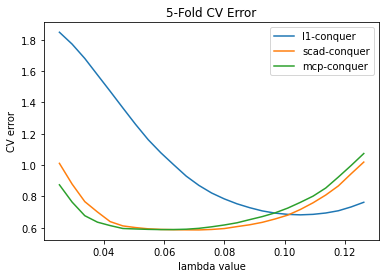

In [16]:
def cv_legend(x, y1, y2, y3):
    plt.clf()
    plt.plot(x,y1,label='l1-conquer')
    plt.plot(x,y2,label='scad-conquer')
    plt.plot(x,y3,label='mcp-conquer')
    plt.title("5-Fold CV Error")
    plt.xlabel("lambda value")
    plt.ylabel("CV error")
    plt.legend()

cv_legend(lambda_seq,
          np.mean(cv_err[0,:,:], axis=1),
          np.mean(cv_err[1,:,:], axis=1),
          np.mean(cv_err[2,:,:], axis=1))